# Regression Problem With Some Useless Variables
In this tutorial we go through a regression problem with a moderate number of explanatory variables (6) that are not equally insightful. 

We run the variable selection analysis of the `kxy` package and confirm it empirically. We then show that our empirical findings are consistent with the data-driven improvability analysis of the `kxy` package.

We use the UCI Yacht Hydrodynamics dataset.

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["NUMEXPR_MAX_THREADS"] = '8'
import warnings
warnings.filterwarnings('ignore')

# Required imports
import pandas as pd
import kxy

In [2]:
# Load the data using the kxy_datasets package (pip install kxy_datasets)
from kxy_datasets.uci_regressions import YachtHydrodynamics
df = YachtHydrodynamics().df

## Variable Selection
### Analysis

In [3]:
var_selection_analysis = df.kxy.variable_selection('Residuary Resistance', problem_type='regression')

[====================================================================================================] 100% ETA: 0s   


In [4]:
var_selection_analysis

,Variable,Running Achievable R-Squared,Running Achievable RMSE
Selection Order,,,
0,No Variable,0.00,1.51e+01
1,Froude Number,0.98,1.90
2,Beam-Draught Ratio,0.99,1.46
3,Longitudinal Position,0.99,1.46
4,Length-Displacement,0.99,1.46
5,Prismatic Coeefficient,0.99,1.46
6,Length-Beam Ratio,0.99,1.46


#### Column Meaning

* `Selection Order`: Order in which variables (see `Variable`) are selected, from the most important to the least important. The first variable selected is the one with the highest mutual information with the label (i.e. that is the most useful when used in isolation). The $(i+1)$-th variable selected is the variable, among all variables not yet selected, that complements all $i$ variables previously selected the most
* `Running Achievable R-Squared`: The highest $R^2$ achievable by a model using all variables selected so far to predict the label.
* `Running Achievable RMSE`: The lowest Root Mean Square Error achievable by a model using all variables selected so far to predict the label.

### Validation
It seems that `Froude Number` is by far the most relevant variable and an almost perfect $R^2$ may be achieved. Let's try to confirm this visually.

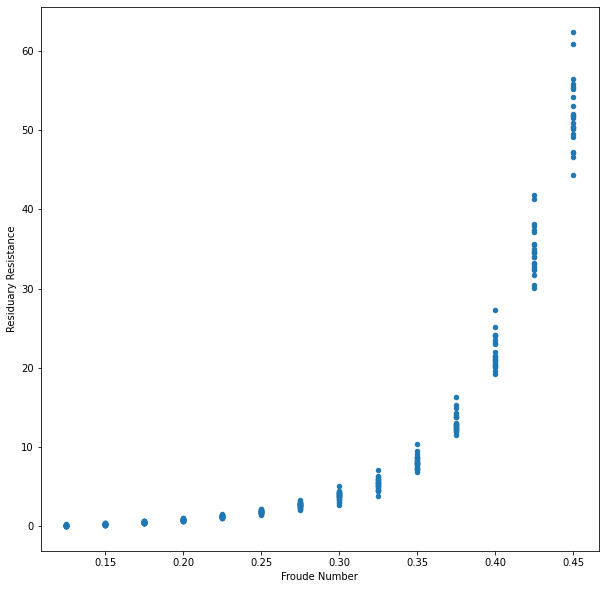

In [5]:
import pylab as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
df[['Residuary Resistance', 'Froude Number']].plot(ax=ax, x='Froude Number',\
            y='Residuary Resistance', kind='scatter')
plt.show()

## Data-Driven Improvability
The variable selection analysis suggests that the other 4 variables do not add much value. Let's try to confirm this with our data-driven improvability analysis.

In [6]:
new_variables = ['Beam-Draught Ratio',\
    'Length-Displacement', 'Longitudinal Position', \
    'Length-Beam Ratio', 'Prismatic Coeefficient']
df.kxy.data_driven_improvability('Residuary Resistance', new_variables, problem_type='regression')

[====================================================================================================] 100% ETA: 0s   


,R-Squared Boost,Log-Likelihood Per Sample Boost,RMSE Reduction
0,0.00,0.00,0.00


As it turns out, our data-driven improvability analysis does indeed suggest that the other 4 variables add negligible value.

## Model-Driven Improvability
Let's train a couple models using `Froude Number` as the only explanatory variable and run our model-driven improvability analysis. We begin with a simple linear model.

### Case I: Linear Regression

In [7]:
# Learning (Basic Linear Regression)
from sklearn.linear_model import LinearRegression
# Training
label_column = 'Residuary Resistance'
prediction_column = 'Prediction'
train_size = 200
df_ = df.copy()
df_ = df_.sample(frac=1, random_state=0) # Shuffle rows
train_df = df.iloc[:train_size]
x_train = train_df[['Froude Number']].values
y_train = train_df[label_column].values
model = LinearRegression().fit(x_train, y_train)

# Testing
test_df = df.iloc[train_size:]
x_test = test_df[['Froude Number']].values
y_test = test_df[label_column].values

# Out-of-sample predictions
predictions = model.predict(x_test)
lr_test_df = test_df.copy()
lr_test_df[prediction_column] = predictions

# Out-of-sample accuracy (R^2)
'Linear Regression Out-Of-Sample R^2: %.2f' % (model.score(x_test, y_test))

'Linear Regression Out-Of-Sample R^2: 0.65'

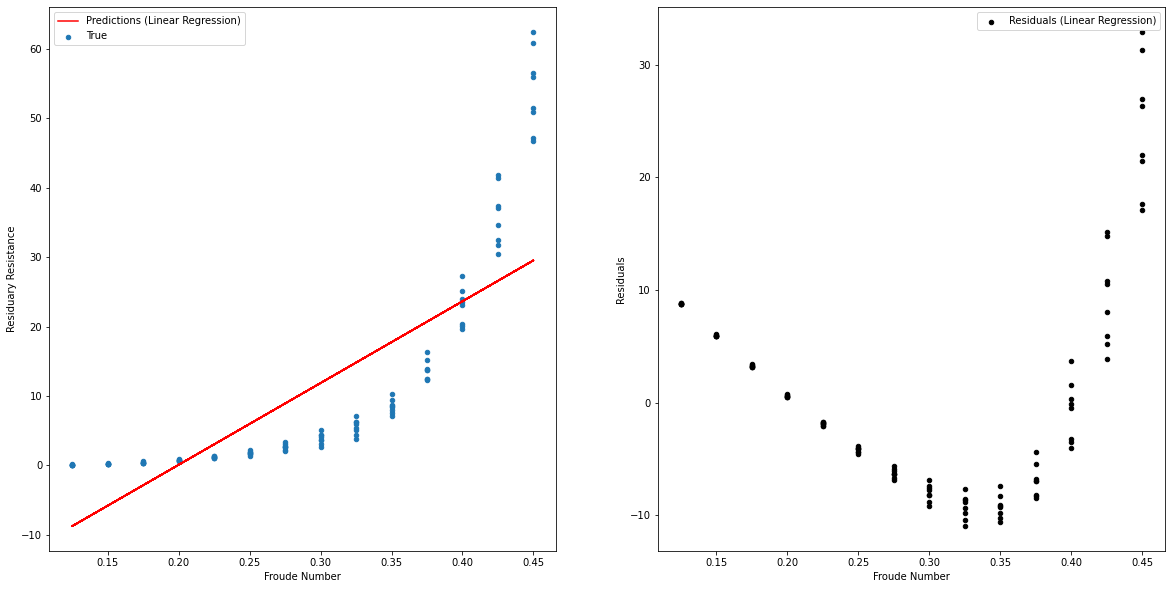

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
lr_test_df[['Prediction', 'Froude Number']].plot(\
        ax=axes[0], x='Froude Number', y='Prediction', \
        color='r')
lr_test_df[['Residuary Resistance', 'Froude Number']].plot(\
        ax=axes[0], x='Froude Number', y='Residuary Resistance', \
        kind='scatter')
lr_test_df['Residuals'] = lr_test_df['Residuary Resistance']-lr_test_df['Prediction']
lr_test_df[['Residuals', 'Froude Number']].plot(\
        ax=axes[1], x='Froude Number', y='Residuals', \
        kind='scatter', label='Residuals (Linear Regression)', color='k')
axes[0].legend(['Predictions (Linear Regression)', 'True'])
plt.show()

In [9]:
lr_test_df[['Froude Number', 'Residuary Resistance', 'Prediction']].kxy\
    .model_driven_improvability(label_column, prediction_column, \
        problem_type='regression')

[====================================================================================================] 100% ETA: 0s   


,Lost R-Squared,Lost Log-Likelihood Per Sample,Lost RMSE,Residual R-Squared,Residual Log-Likelihood Per Sample,Residual RMSE
0,0.00,0.00,0.00,0.98,-1.73,1.40


### Interpretation 
*Lost performance metrics* represent the performance that was irreversibly lost while training the moodel. When the model's prediction function is in a 1-to-1 relationship with the input, nothing can be lost during training as the effect of training can be *undone*. 

Indeed, if a poor model has 1-to-1 prediction function $x \to g(x)$, and the best model has prediction function $x \to f(x)$, then we may always achieve optimal performance from $z=g(x)$ by simply using the model with prediction function $z \to f\left(g^{-1}(z)\right)$. Note however that the prediction function of a trained model can only be 1-to-1 when the input is 1D, otherwise the trained model will irreversibly lose information about the input distribution.

In the case of our trained 1D linear regression model, the prediction function is 1-to-1 and, as such, the training process is lossless. Once more, the analysis from the `kxy` package matches our expectation.

*Residual performance metrics* represent the performance that may be achieved when using explanatory variables to explain regression residuals. In other words, they represent how much **juice** is still left in regression residuals. The more juice is extracted by the trained model, the less juice will be left in residuals. For these residual performance metrics to be 0, the learned model needs to be truly optimal. 

The `kxy` model-driven improvability analysis suggests that residuals of the trained linear regression model can be predicted almost perfectly using `Froude Number`, which is consistent with the residuals plot above.


### Case 2: Gaussian Process Regression
Next we try Gaussian Proceess regression to capture non-linearities. We use the RBF kernel with fixed input scale 1.0 and output scale 10.

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

x_train = train_df[['Froude Number']].values
y_train = train_df[label_column].values

x_test = test_df[['Froude Number']].values
y_test = test_df[label_column].values

# Fit
gp_model = GaussianProcessRegressor(10.0 * RBF(1.0))
gp_model.fit(x_train, y_train)

# Out-of-sample predictions
gp_test_df = test_df.copy()
gp_test_df[prediction_column] = gp_model.predict(x_test)

# Out-of-sample accuracy (R^2)
'Gaussian Process Regression Out-Of-Sample R^2: %.2f' % (gp_model.score(x_test, y_test))

'Gaussian Process Regression Out-Of-Sample R^2: 0.98'

In [11]:
gp_test_df[['Froude Number', 'Residuary Resistance', 'Prediction']].kxy\
    .model_driven_improvability(label_column, prediction_column, \
        problem_type='regression')

[====================================================================================================] 100% ETA: 0s   


,Lost R-Squared,Lost Log-Likelihood Per Sample,Lost RMSE,Residual R-Squared,Residual Log-Likelihood Per Sample,Residual RMSE
0,0.00,0.00,0.00,0.08,-1.57,2.18


Lost performance metrics still have negligible values as the prediction function is 1-to-1. 

Moreover, residual performances are reduced, which is an indication that our GP model is less suboptimal than our linear regression model. A lower `Residual RMSE` typically implies that residuals have a smaller variance. A lower `Residual R-Squared` illustrates that residuals are harder to predict using the explanatory variables, which implies the model is more effective --- when the model is optimal, residuals are independant from explanatory variables.

We note however that the `kxy` analysis suggests that there is still a lot of juice left in our GP residuals. This can be visually confirmed on the figure below, where we see that our trained GP model undershoots for large `Froude Number` values. This is most likely due to the fact that we did not learn kernel hyper-parameters. 

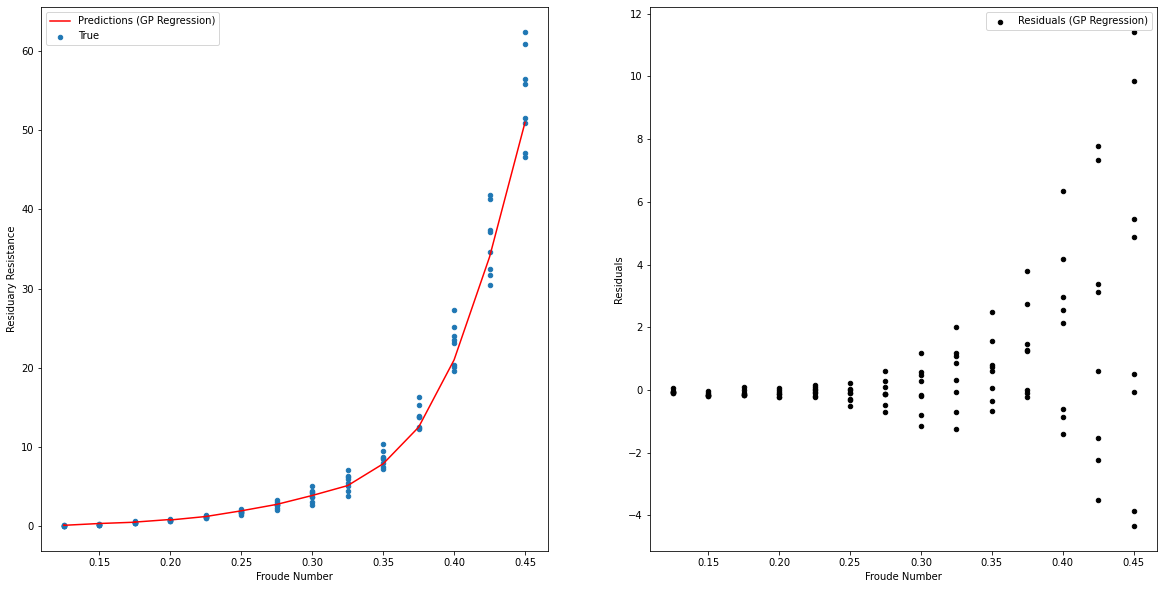

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
gp_test_df[['Prediction', 'Froude Number']].sort_values(by=['Froude Number']).\
        plot(ax=axes[0], x='Froude Number', y='Prediction', \
        color='r')
gp_test_df[['Residuary Resistance', 'Froude Number']].plot(\
        ax=axes[0], x='Froude Number', y='Residuary Resistance', \
        kind='scatter')
gp_test_df['Residuals'] = gp_test_df['Residuary Resistance']-gp_test_df['Prediction']
gp_test_df[['Residuals', 'Froude Number']].plot(\
        ax=axes[1], x='Froude Number', y='Residuals', \
        kind='scatter', label='Residuals (GP Regression)', color='k')
axes[0].legend(['Predictions (GP Regression)', 'True'])
plt.show()